In [1]:
import sys
import os

# Get the root directory
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the root directory to the Python path
sys.path.append(root_dir)

In [2]:
import torch
from kan import *
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, LabelEncoder
import pandas as pd

if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


In [3]:
def load_custom_dataset(csv_file, scale=False):
    # Load the CSV file into a DataFrame
    df = pd.read_csv(csv_file)
    
    # Separate features and target
    features = df.iloc[:, :-1].values  # All columns except the last one
    target = df.iloc[:, -1].values     # The last column (Class)
    
    # Normalize target labels to start from 0
    target = target - target.min()

    if scale:
        scaler = StandardScaler()
        features = scaler.fit_transform(features)
    
    # Convert to PyTorch tensors
    features_tensor = torch.tensor(features, dtype=torch.float32)
    target_tensor = torch.tensor(target, dtype=torch.long)
    
    # Split into train and test sets
    train_data, test_data, train_target, test_target = train_test_split(
        features_tensor, target_tensor, test_size=0.3, random_state=42
    )
    
    # Create data loaders (optional, for batching and shuffling)
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(train_data, train_target), batch_size=1, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(test_data, test_target), batch_size=1, shuffle=False
    )
    
    # Initialize empty tensors for all data
    train_inputs = torch.empty(0, features_tensor.size(1), device=device)
    train_labels = torch.empty(0, dtype=torch.long, device=device)
    test_inputs = torch.empty(0, features_tensor.size(1), device=device)
    test_labels = torch.empty(0, dtype=torch.long, device=device)
    
    # Concatenate all batches into a single tensor
    for data, labels in train_loader:
        train_inputs = torch.cat((train_inputs, data.to(device)), dim=0)
        train_labels = torch.cat((train_labels, labels.to(device)), dim=0)

    for data, labels in test_loader:
        test_inputs = torch.cat((test_inputs, data.to(device)), dim=0)
        test_labels = torch.cat((test_labels, labels.to(device)), dim=0)
    
    # Create a dictionary to store the dataset
    dataset = {
        'train_input': train_inputs,
        'test_input': test_inputs,
        'train_label': train_labels,
        'test_label': test_labels
    }
    
    return dataset


# Path to your CSV file
csv_file = "data/gas.csv"


In [4]:
# Step 3: Define accuracy metrics
def train_acc():
    return torch.mean((torch.argmax(model(custom_dataset['train_input']), dim=1) == custom_dataset['train_label']).float())

def test_acc():
    return torch.mean((torch.argmax(model(custom_dataset['test_input']), dim=1) == custom_dataset['test_label']).float())

# Create Scale dataset

In [5]:
# Load the dataset
custom_dataset = load_custom_dataset(csv_file, scale=True)

# Print the shapes of the tensors
print("Train data shape:", custom_dataset['train_input'].shape)
print("Train target shape:", custom_dataset['train_label'].shape)
print("Test data shape:", custom_dataset['test_input'].shape)
print("Test target shape:", custom_dataset['test_label'].shape)

Train data shape: torch.Size([9737, 129])
Train target shape: torch.Size([9737])
Test data shape: torch.Size([4173, 129])
Test target shape: torch.Size([4173])


In [8]:
# Step 2: Define the KAN model
model = KAN(
    width=[custom_dataset['train_input'].shape[1], 64, 32, len(torch.unique(custom_dataset['train_label']))], 
    grid=3, 
    k=3, 
    seed=381, 
    device=device
)

# Step 4: Train the KAN model
results = model.fit(
    custom_dataset,
    opt="Adam",
    metrics=(train_acc, test_acc),
    loss_fn=torch.nn.CrossEntropyLoss(),
    steps=30,  # Increase steps for more training iterations
    lamb=0.01,  # Regularization strength
    lamb_entropy=10.0  # Entropy regularization strength
)

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 9.98e+00 | test_loss: 1.19e+01 | reg: 1.61e+04 | : 100%|█| 30/30 [00:34<00:00,  1.15s/


saving model version 0.1


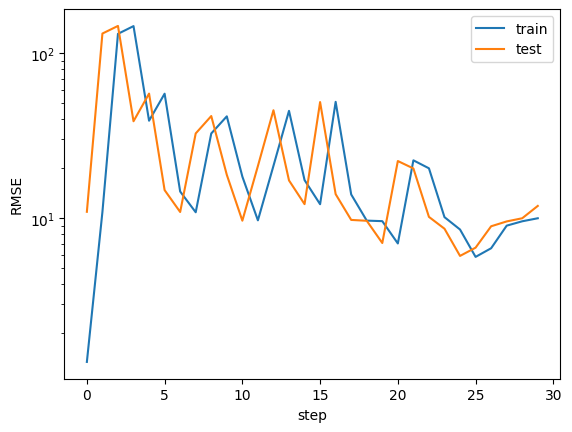

In [9]:
plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

In [10]:
results['train_acc'][-1], results['test_acc'][-1]

(0.17428365349769592, 0.180685356259346)

# Create NO-Scale dataset

In [11]:
# Load the dataset
custom_dataset = load_custom_dataset(csv_file, scale=False)

# Print the shapes of the tensors
print("Train data shape:", custom_dataset['train_input'].shape)
print("Train target shape:", custom_dataset['train_label'].shape)
print("Test data shape:", custom_dataset['test_input'].shape)
print("Test target shape:", custom_dataset['test_label'].shape)

Train data shape: torch.Size([9737, 129])
Train target shape: torch.Size([9737])
Test data shape: torch.Size([4173, 129])
Test target shape: torch.Size([4173])


In [12]:
# Step 2: Define the KAN model
model = KAN(
    width=[custom_dataset['train_input'].shape[1], 64, 32, len(torch.unique(custom_dataset['train_label']))], 
    grid=3, 
    k=3, 
    seed=381, 
    device=device
)

# Step 4: Train the KAN model
results = model.fit(
    custom_dataset,
    opt="Adam",
    metrics=(train_acc, test_acc),
    loss_fn=torch.nn.CrossEntropyLoss(),
    steps=30,  # Increase steps for more training iterations
    lamb=0.01,  # Regularization strength
    lamb_entropy=10.0  # Entropy regularization strength
)

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.13e+01 | test_loss: 9.56e+00 | reg: 1.96e+04 | : 100%|█| 30/30 [00:34<00:00,  1.13s/


saving model version 0.1


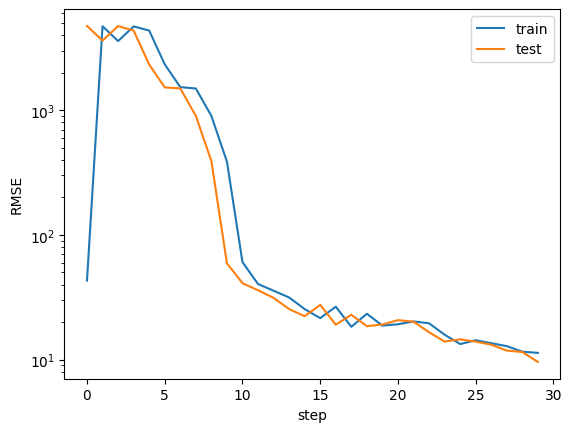

In [13]:
plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

In [14]:
results['train_acc'][-1], results['test_acc'][-1]

(0.242682546377182, 0.23891685903072357)

# Change opt to LBFGS with Scaled dataset

In [20]:
# Load the dataset
custom_dataset = load_custom_dataset(csv_file, scale=True)

# Print the shapes of the tensors
print("Train data shape:", custom_dataset['train_input'].shape)
print("Train target shape:", custom_dataset['train_label'].shape)
print("Test data shape:", custom_dataset['test_input'].shape)
print("Test target shape:", custom_dataset['test_label'].shape)

Train data shape: torch.Size([9737, 129])
Train target shape: torch.Size([9737])
Test data shape: torch.Size([4173, 129])
Test target shape: torch.Size([4173])


In [21]:
# Step 2: Define the KAN model
model = KAN(
    width=[custom_dataset['train_input'].shape[1], 64, 32, len(torch.unique(custom_dataset['train_label']))], 
    grid=3, 
    k=3, 
    seed=381, 
    device=device
)

# Step 4: Train the KAN model
results = model.fit(
    custom_dataset,
    opt="LBFGS",
    metrics=(train_acc, test_acc),
    loss_fn=torch.nn.CrossEntropyLoss(),
    steps=30,  # Increase steps for more training iterations
    lamb=0.01,  # Regularization strength
    lamb_entropy=10.0  # Entropy regularization strength
)

checkpoint directory created: ./model
saving model version 0.0


| train_loss: nan | test_loss: nan | reg: nan | : 100%|█████████████| 30/30 [07:18<00:00, 14.63s/it]


saving model version 0.1


# Change opt to LBFGS with NO-Scaled dataset

In [5]:
# Load the dataset
custom_dataset = load_custom_dataset(csv_file, scale=False)

# Print the shapes of the tensors
print("Train data shape:", custom_dataset['train_input'].shape)
print("Train target shape:", custom_dataset['train_label'].shape)
print("Test data shape:", custom_dataset['test_input'].shape)
print("Test target shape:", custom_dataset['test_label'].shape)

Train data shape: torch.Size([9737, 129])
Train target shape: torch.Size([9737])
Test data shape: torch.Size([4173, 129])
Test target shape: torch.Size([4173])


In [6]:
# Step 2: Define the KAN model
model = KAN(
    width=[custom_dataset['train_input'].shape[1], 64, 32, len(torch.unique(custom_dataset['train_label']))], 
    grid=3, 
    k=3, 
    seed=381, 
    device=device
)

# Step 4: Train the KAN model
results = model.fit(
    custom_dataset,
    opt="LBFGS",
    metrics=(train_acc, test_acc),
    loss_fn=torch.nn.CrossEntropyLoss(),
    steps=30,  # Increase steps for more training iterations
    lamb=0.01,  # Regularization strength
    lamb_entropy=10.0  # Entropy regularization strength
)

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.87e-01 | test_loss: 4.65e-01 | reg: 4.15e+02 | : 100%|█| 30/30 [01:59<00:00,  4.00s/


saving model version 0.1


In [8]:
results['train_acc'][-1], results['test_acc'][-1]

(0.971038281917572, 0.9700455665588379)

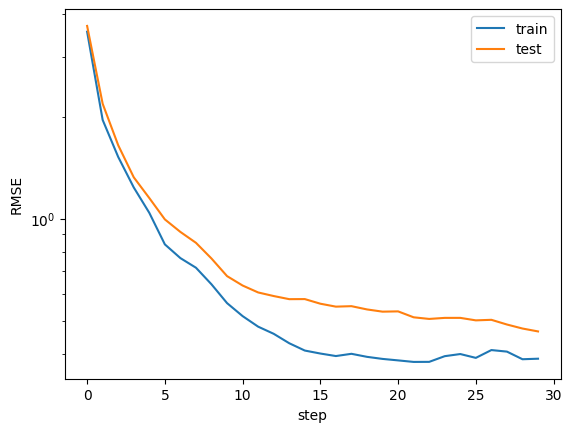

In [7]:
plt.plot(results['train_loss'])
plt.plot(results['test_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')